# 01: Avelleneda-Stoikov Baseline Functionality

In [46]:
# So that when code in a different file is modified, the entire kernel doesn't need to be restarted
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Parquet file, parse as OrderEvents

In [ ]:
import pandas as pd
import pyarrow as pa
import lob_market_making_sim.io.loader as loader
# Import dataframe that has been built previously
#df = pd.read_parquet('data/parquet/AMZN_2025-06-12.parquet')
# # Convert dataframe to Iterable[OrderEvent]
#events = loader.arrow_to_events(pa.Table.from_pandas(df))

from pathlib import Path
path = Path.cwd().parent
data_src = path / "data" / "test" / "AAPL_2012-06-21_34200000_57600000_message_1.csv"
arrow = loader.lobster_to_arrow(data_src)

events = loader.arrow_to_events(arrow)

[OrderEvent(ts=34200.004241176, etype=<EventType.ADD: 1>, oid=16113575, size=18, price=585.33, direction=<Direction.BUY: 1>),
 OrderEvent(ts=34200.025551909, etype=<EventType.ADD: 1>, oid=16120456, size=18, price=585.9100000000001, direction=<Direction.SELL: -1>),
 OrderEvent(ts=34200.201743336, etype=<EventType.DELETE: 3>, oid=16120456, size=18, price=585.9100000000001, direction=<Direction.SELL: -1>),
 OrderEvent(ts=34200.201780978, etype=<EventType.DELETE: 3>, oid=16120480, size=18, price=585.9200000000001, direction=<Direction.SELL: -1>),
 OrderEvent(ts=34200.205573445, etype=<EventType.ADD: 1>, oid=16167159, size=18, price=585.36, direction=<Direction.BUY: 1>),
 OrderEvent(ts=34200.271739507, etype=<EventType.ADD: 1>, oid=3647217, size=20, price=585.73, direction=<Direction.BUY: 1>),
 OrderEvent(ts=34200.271739507, etype=<EventType.ADD: 1>, oid=5740544, size=40, price=585.74, direction=<Direction.SELL: -1>),
 OrderEvent(ts=34200.275016159, etype=<EventType.EXECUTE_VISIBLE: 4>, oid

## Configure OrderBook, Engine, and Avellaneda Strategy

In [48]:
from lob_market_making_sim.core.order_book import OrderBookL1
from lob_market_making_sim.core.engine import ReplayEngine
from lob_market_making_sim.models.avellaneda import ASParams, AvellanedaStoikov
from lob_market_making_sim.io.schema import TICK_SIZE
ob = OrderBookL1()
asparams = ASParams(
    gamma = 0.02,
    kappa = 100.0,
    sigma = 0.30,          # $ / sqrt(sec)
    qmax  = 1_000
)
strategy = AvellanedaStoikov(params = asparams)
engine = ReplayEngine(ob, strategy)
engine.run(events)

quote_log = engine.quote_log

In [49]:
print(f'P&L: {engine.cash + engine.inv * engine.ob.midprice()}')
print(f'cash: {engine.cash}')
print(f'inventory: {engine.inv}')

P&L: 67.54982002399993
cash: 22396.549820024004
inventory: -100


## Plot quotes and midprices

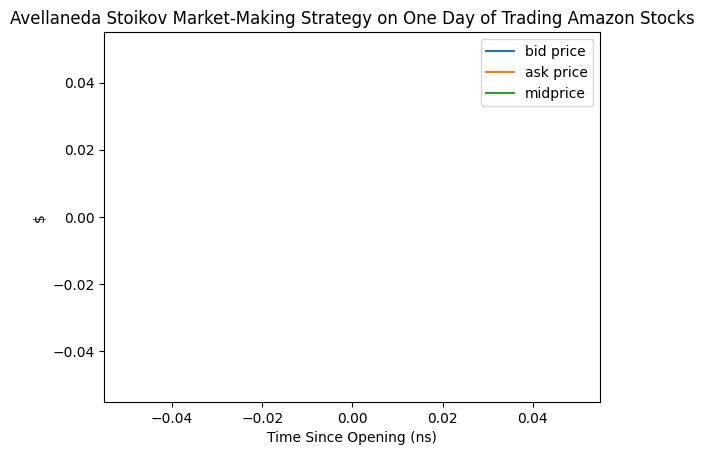

In [50]:
import matplotlib.pyplot as plt

# Drop the first 100 lines of data, as prices rise from 0
quote_df = pd.DataFrame(quote_log, columns=["timestamp", "bid", "ask", "midprice", "inventory"])[100:]
bid = quote_df["bid"]
ask = quote_df["ask"]
mid = quote_df["midprice"]

plt.plot(bid, label="bid price")
plt.plot(ask, label="ask price")
plt.plot(mid, label="midprice")
plt.xlabel("Time Since Opening (ns)")
plt.ylabel("$")
plt.title("Avellaneda Stoikov Market-Making Strategy on One Day of Trading Amazon Stocks")
plt.legend()